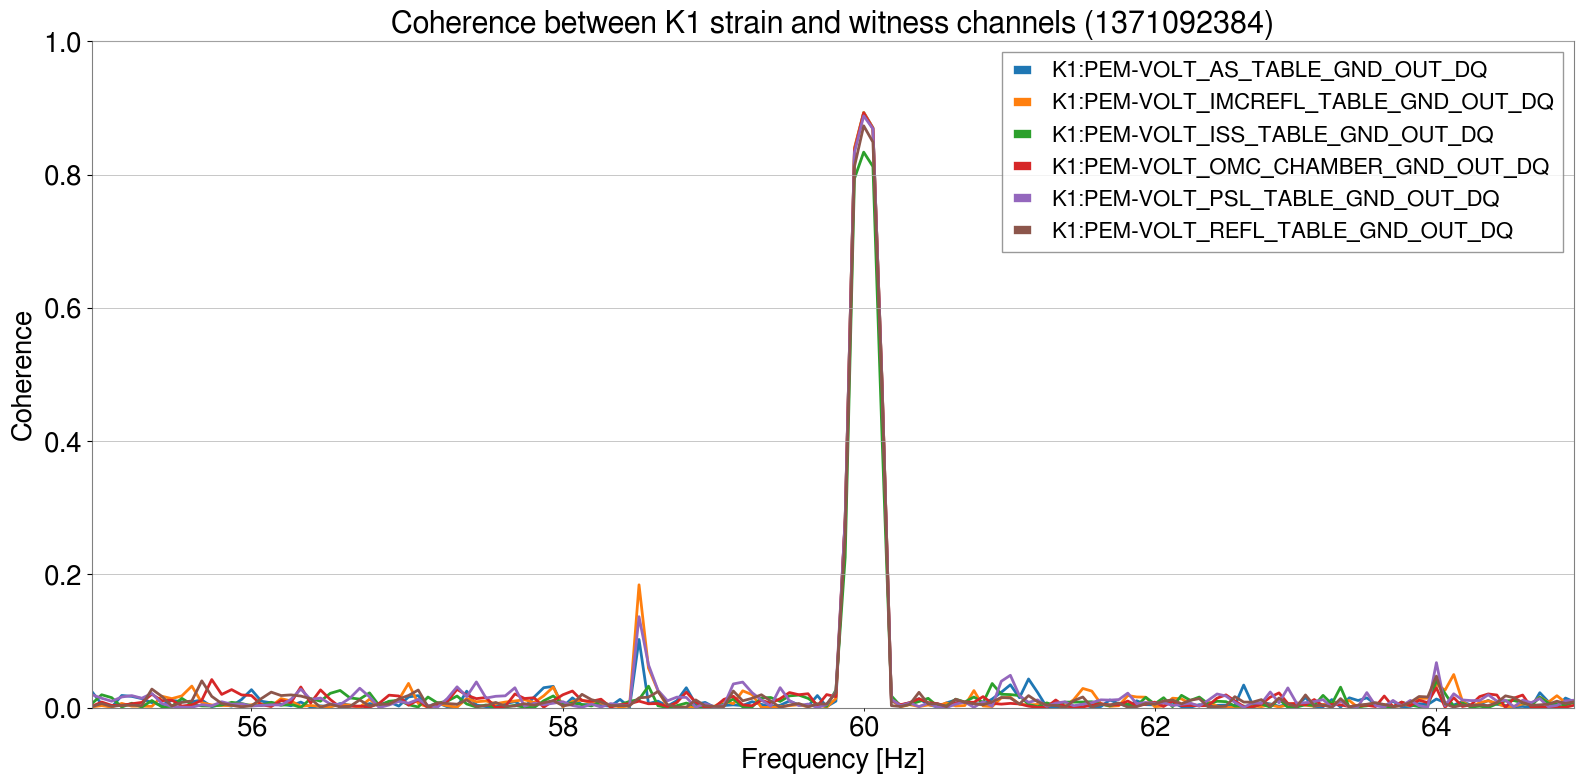

Coherence plot saved to /home/shu-wei.yeh/Results/hardware_inj_test-new2/coherence_plot_55Hz-65Hz-1371092384.png


In [3]:
import os
import yaml
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries, TimeSeriesDict

# Load configuration from YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Extract configuration values
start_times = config['start_times']
duration = config['duration']
strain_channel = config['strain_channel']
wit_channels = config['wit_channels']
fftlength = config['fftlength']
overlap = config['overlap']
fl = config['fl']
fh = config['fh']
folder_path = config['folder_path']
output_fig_path = config['output_fig_path']

# Ensure output directory exists
os.makedirs(output_fig_path, exist_ok=True)

# Read channels from file
with open(wit_channels, 'r') as file:
    channels = [line.strip() for line in file]

def folder_files(j):
    return f'{folder_path}{int((j - j % 100000) / 100000)}/K-K1_R-{j}-32.gwf'

# Read data for each start time
def read_data(start_time):
    end_time = start_time + duration
    first_file = int(start_time - start_time % 32)
    last_file = int(end_time - end_time % 32)
    
    strain_channel_files = [folder_files(j) for j in range(first_file, last_file + 1, 32)]
    
    strain_data = TimeSeriesDict.read(
        strain_channel_files, 
        strain_channel, 
        start=start_time, 
        end=end_time
    )[strain_channel[0]]
    
    witness_data_dict = TimeSeriesDict.read(
        strain_channel_files, 
        channels, 
        start=start_time, 
        end=end_time
    )
    
    return strain_data, witness_data_dict

# Coherence calculation and plotting
def coh_between_strain_and_witness_channels(start_times):
    for start_time in start_times:
        strain_data, witness_data_dict = read_data(start_time)
        
        fig, ax = plt.subplots(figsize=(16, 8))
        
        for channel in channels:
            witness_data = witness_data_dict[channel]
            
            if strain_data.sample_rate != witness_data.sample_rate:
                strain_data_resampled = strain_data.resample(witness_data.sample_rate)
            else:
                strain_data_resampled = strain_data
            
            coherence = TimeSeries.coherence(
                strain_data_resampled, 
                witness_data, 
                fftlength=fftlength, 
                overlap=overlap, 
                window='hann'
            )
            
            ax.plot(coherence.frequencies.value, coherence.value, label=f'{channel}', linewidth=2)
        
        ax.set_title(f'Coherence between K1 strain and witness channels ({start_time})', fontsize=22)
        ax.set_ylabel('Coherence', fontsize=20)
        ax.set_xlabel('Frequency [Hz]', fontsize=20)
        ax.set_xscale('log')
        ax.set_yscale('linear')
        ax.set_xlim([fl, fh])
        ax.set_ylim([0, 1])
        ax.legend(loc='best', prop={"size": 16})
        ax.tick_params(axis='y', labelsize=20)
        ax.tick_params(axis='both', which='minor', labelsize=20)
        
        plt.tight_layout()
        output_path = os.path.join(output_fig_path, f'coherence_plot_{fl}Hz-{fh}Hz-{start_time}.png')
        # plt.savefig(output_path, facecolor='white', dpi=300)
        plt.show()
        # plt.close()
        print(f'Coherence plot saved to {output_path}')

# Call the function to plot coherence
coh_between_strain_and_witness_channels(start_times)